In [2]:

from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import DynUNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import json
from datetime import datetime
from data_preparation2 import DataHandling 
#from UNet_model import create_unet
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    SpatialPadd, ScaleIntensityd, CenterSpatialCropd
)
from monai.transforms import Compose, Invertd, SaveImaged
from monai.inferers import sliding_window_inference
from monai.data import decollate_batch
import torch
from monai.transforms import NormalizeIntensityd, RandWeightedCropd, RandSpatialCropSamplesd
import json
import math
import random
from collections import defaultdict

In [3]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
output_dir = config["output_dir"]


In [4]:
from data_preparation import DataHandling

dataset = DataHandling(ga_data_dir, train_mode="NAC", target_mode="MAC", external_center='C5')
train_files = dataset.get_data_split('train')
val_files = dataset.get_data_split('val')
test_files = dataset.get_data_split('test')
print(len(test_files))
print(len(val_files))
print(len(train_files))

20
33
131


In [5]:
from data_preparation import LoaderFactory
loader_factory = LoaderFactory(
    train_files=train_files,
    val_files=val_files,
    test_files=test_files,
    patch_size = [168, 168, 16],
    spacing = [4.07, 4.07, 3.00],
    spatial_size = (168, 168, 320)
    )

# Get the DataLoader for each dataset type
# train_loader = loader_factory.get_loader('train', batch_size=4, num_workers=2, shuffle=True)
# val_loader = loader_factory.get_loader('val', batch_size=1, num_workers=2, shuffle=False)
test_loader = loader_factory.get_loader('test', batch_size=1, num_workers=2, shuffle=False)



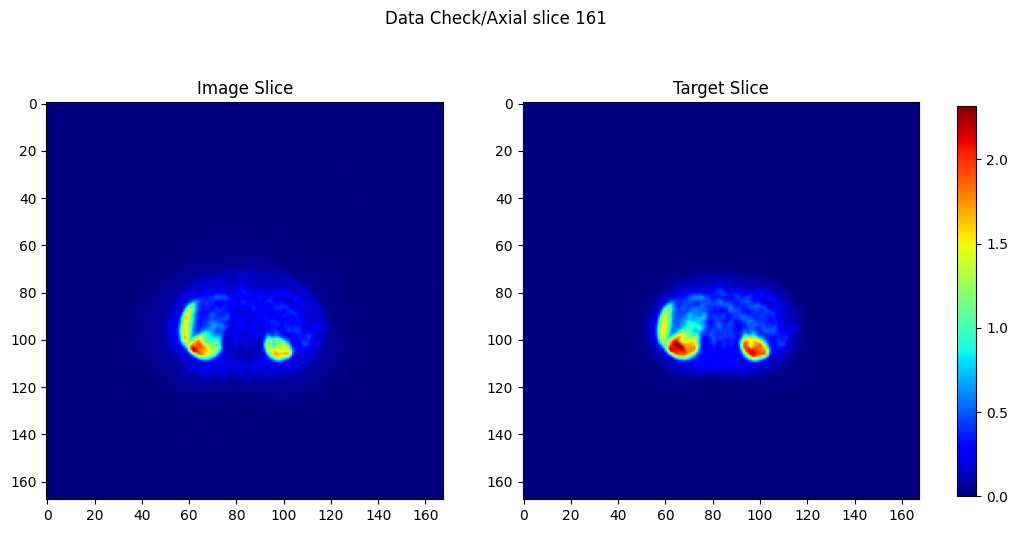

In [6]:
from data_preparation import visualize_axial_slice


slice_index = 161  # Example slice index, adjust based on your data
visualize_axial_slice(test_loader, slice_index)


In [7]:
from utils import find_last_saved_model, parse_loss_values

# log_filename = 'log_2_26_8_17.txt'
# log_filename = 'log_3_4_12_4.txt'
# log_filename = 'log_3_4_12_41.txt'
log_filename = 'log_3_18.txt'

log_filepath = log_dir + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_3_18_22_10.pth, Best Metric: 0.0664, Epoch: 298


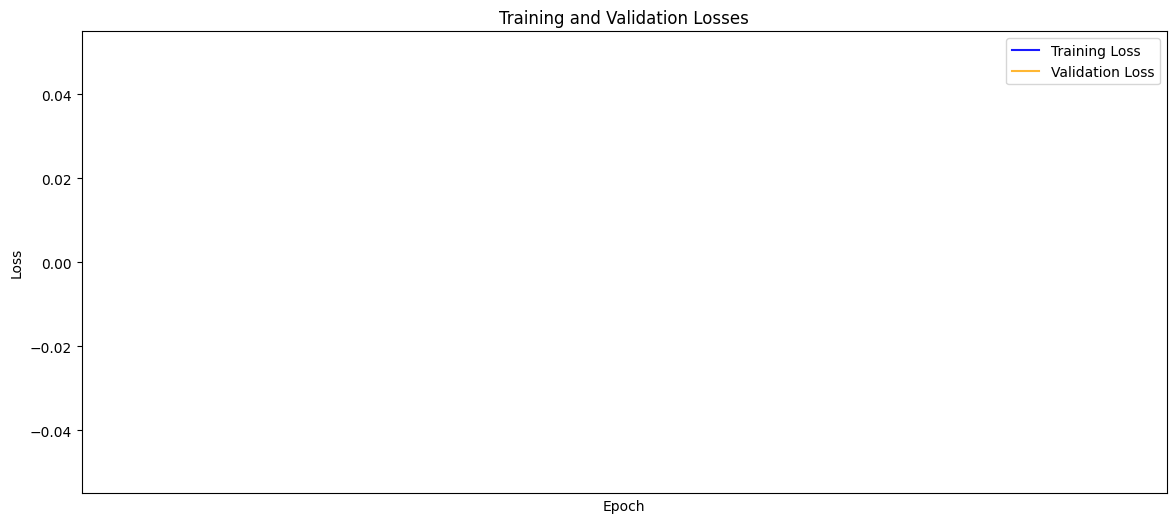

In [8]:
train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 10))  # Adjust the x-axis ticks if needed
plt.show()


In [9]:
import os
import torch
from model_maker import get_network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = get_network(patch_size = [168, 168, 16], spacing = [4.07, 4.07, 3.00])
model = model.to(device)


DyUnet is set:
Kernel size:  [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides:  [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 1]]


In [10]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(log_dir, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    model.load_state_dict(torch.load(model_path))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")

Model file model_3_18_22_10.pth is loading.


In [11]:
# Extract file names
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]
test_name


[('007026_C5_RJ_.nii', '007026_C5_RJ_.nii'),
 ('007035_C5_RJ_.nii', '007035_C5_RJ_.nii'),
 ('007037_C5_RJ_.nii', '007037_C5_RJ_.nii'),
 ('007038_C5_RJ_.nii', '007038_C5_RJ_.nii'),
 ('007042_C5_RJ_.nii', '007042_C5_RJ_.nii'),
 ('007043_C5_RJ_.nii', '007043_C5_RJ_.nii'),
 ('007046_C5_RJ_.nii', '007046_C5_RJ_.nii'),
 ('007051_C5_RJ_.nii', '007051_C5_RJ_.nii'),
 ('007057_C5_RJ_.nii', '007057_C5_RJ_.nii'),
 ('007058_C5_RJ_.nii', '007058_C5_RJ_.nii'),
 ('007066_C5_RJ_.nii', '007066_C5_RJ_.nii'),
 ('007067_C5_RJ_.nii', '007067_C5_RJ_.nii'),
 ('001595_C1_RZ_.nii', '001595_C1_RZ_.nii'),
 ('001216_C1_RZ_.nii', '001216_C1_RZ_.nii'),
 ('002301_C2_IM_.nii', '002301_C2_IM_.nii'),
 ('002401_C2_IM_.nii', '002401_C2_IM_.nii'),
 ('003232_C3_KH_.nii', '003232_C3_KH_.nii'),
 ('003221_C3_KH_.nii', '003221_C3_KH_.nii'),
 ('004136_C4_SH_.nii', '004136_C4_SH_.nii'),
 ('004123_C4_SH_.nii', '004123_C4_SH_.nii')]

100%|██████████| 3/3 [00:40<00:00, 13.60s/it]


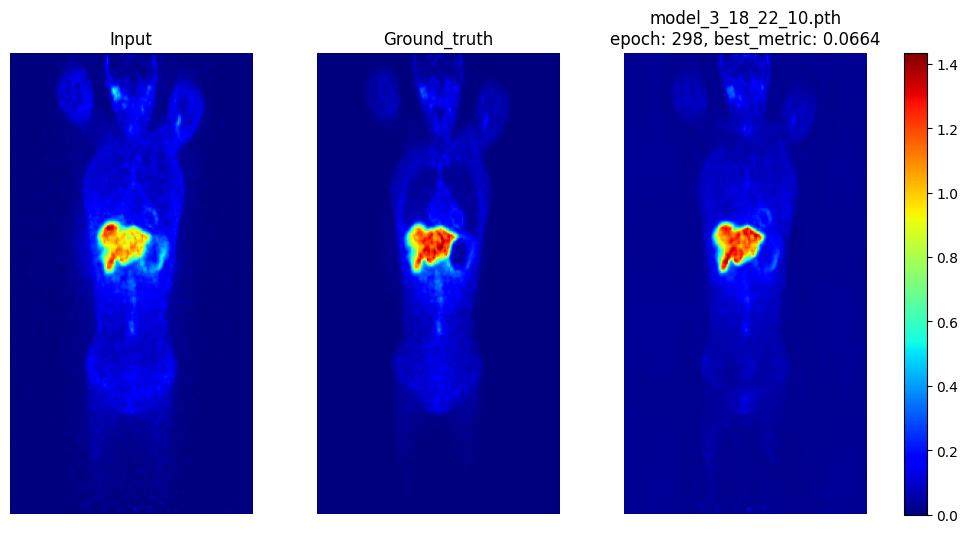

In [18]:
import torch
from data_preparation import visualize_coronal_slice

roi_size = (160, 160, 32)
sw_batch_size = 64
slice_number = 80

with torch.no_grad():
    for i, data in enumerate(test_loader):

        predict = sliding_window_inference(data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.70)
        
        visualize_coronal_slice(data, predict, slice_number, f"{bestmodel_filename}\nepoch: {best_epoch}, best_metric: {best_metric}", Norm=False)
        if i == 0:
            break


In [ ]:
# # Extract file names


# post_transforms = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=loader_factory.get_test_transforms(),
#             orig_keys="image",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="image_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#         ),
#         SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir=output_dir, output_postfix="dl_dyn_test", resample=False),
#     ]
# )
# model.eval()

# with torch.no_grad():
#     for test_data in test_loader:
#         test_inputs = test_data["image"].to(device)
#         test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model, overlap=0.90)
#         post_processed = [post_transforms(i) for i in decollate_batch(test_data)]

